In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

# Partie 1 : Inspection des données & Nettoyages des données

<span style="color: #008080">@ Télécharger les fichiers de format csv et puis les palcent dans des dataframes nommés séparemment `loandown_2015` et `loandown_2016`. Les colonnes du fichier sont uniquement séparées par le virgule `,`. </span> 

In [2]:
loandown_2015 = pd.read_csv('2015-building-energy-benchmarking.csv', sep=',',low_memory=False)
loandown_2016 = pd.read_csv('2016-building-energy-benchmarking.csv', sep=',',low_memory=False)

<span style="color: #008080"> @ Nettoytage : On sépare la variable `Location` de `loandown_2015` en trois nouveaux colonnes : `Latitude, Longitude, Human_adress`.</span>

In [3]:
loandown_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

In [4]:
import json
import ast


data_2015= pd.DataFrame()
for idx, row in loandown_2015.iterrows():

    data_dict = ast.literal_eval(row['Location'])
    lat = data_dict['latitude']
    lon = data_dict['longitude']
    human_address = data_dict['human_address'] 

    normalize = pd.Series(json.loads(data_dict['human_address']))
    row = row.drop('Location')

    cols = list(row.index) + ['Latitude', 'Longitude', 'Human_adress'] + list(normalize.index)
    temp_df = pd.DataFrame([list(row) + [lat, lon, human_address] + list(normalize)], columns = cols )
    data_2015 = data_2015.append(temp_df).reset_index(drop=True)

<span style="color: #008080"> @ Nettoyage : On s'intéresse de près aux émmisions des bâtiments non destinés à l'habitation: `NON RESIDENTIEL` 
- On stock ces bâtiments dans un dataframe, on le nomme `data_2015`.</span>

In [5]:
data_2015=data_2015.loc[data_2015['BuildingType'].isin({'NonResidential','SPS-District K-12','Nonresidential COS'})] 

In [6]:
data_2015.shape

(1628, 53)

<span style="color: #008080"> @ Nettoyage : On s'intéresse de près aux émmisions des bâtiments non destinés à l'habitation: `NON RESIDENTIEL` 
- On stock ces bâtiments dans un dataframe, on le nomme `data_2016`.</span>

In [7]:
data_2016=loandown_2016.loc[loandown_2016['BuildingType'].isin({'NonResidential','SPS-District K-12','Nonresidential COS','Nonresidential WA'})] 
data_2016.shape

(1644, 46)

<span style="color: #008080"> @ Nettoyage : On supprime les lignes de valeurs "Low outlier et Hign outlier" dans la variable `Outlier` des datasets `data_2015` et `data_2016`.  </span>

In [8]:
data_2015=data_2015.drop((data_2015.loc[data_2015['Outlier']=='Low Outlier']).index)
data_2015=data_2015.drop((data_2015.loc[data_2015['Outlier']=='High Outlier']).index)
data_2016=data_2016.drop((data_2016.loc[data_2016['Outlier']=='Low outlier']).index)
data_2016=data_2016.drop((data_2016.loc[data_2016['Outlier']=='High outlier']).index)

<span style="color: #FF00FF">  @ Filtrage : On choisit les variables ce qui nous s'intéresse pour prédir `les émissions de CO²` et `la consommation total d'énergie`.
- Définiton des variables : https://www.opendatanetwork.com/dataset/data.seattle.gov/2bpz-gwpy
- 'GHGEmissions(MetricTonsCO2e)'
- 'SiteEnergyUse(kBtu)' : La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie, ajustée à ce que la propriété aurait consommé dans des conditions météorologiques moyennes sur 30 ans.


 </span>

In [9]:
data_2015=data_2015[[ 
    'BuildingType',
    'ListOfAllPropertyUseTypes',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'TaxParcelIdentificationNumber',
    'CouncilDistrictCode',
    'Neighborhood',
    'Latitude',
    'Longitude',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'GHGEmissions(MetricTonsCO2e)',
    'ENERGYSTARScore',
    'SiteEnergyUse(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kBtu)',
    'NaturalGas(kBtu)',
    'OtherFuelUse(kBtu)']] 

In [10]:
data_2016=data_2016.rename(columns={'TotalGHGEmissions': 'GHGEmissions(MetricTonsCO2e)'})

In [11]:
data_2016=data_2016[[ 
    'BuildingType',
    'ListOfAllPropertyUseTypes',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'TaxParcelIdentificationNumber',
    'CouncilDistrictCode',
    'Neighborhood',
    'Latitude',
    'Longitude',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'GHGEmissions(MetricTonsCO2e)',
    'ENERGYSTARScore',
    'SiteEnergyUse(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kBtu)',
    'NaturalGas(kBtu)']] 

<span style="color: #008080"> @ Création du DataFrame de données
-
- On fusionne les deux datasets `data_2015` et `data_2016` et les assigne à `data`.</span>

In [12]:
frames =[data_2015,data_2016] 
data = pd.concat(frames, ignore_index=True)
print(data.shape)

(3224, 20)


<span style="color: #008080"> @ Pré-traitement des données
-
- On transforme les varaibles `SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu) et OtherFuelUse(kBtu)` en pourcentage. Puit on change les noms de ces variables.</span>

In [13]:
data['SteamUse(kBtu)']=data['SteamUse(kBtu)']/data['SiteEnergyUse(kBtu)']
data['Electricity(kBtu)'] = data['Electricity(kBtu)']/data['SiteEnergyUse(kBtu)']
data['NaturalGas(kBtu)'] = data['NaturalGas(kBtu)']/data['SiteEnergyUse(kBtu)']
data['OtherFuelUse(kBtu)'] = data['OtherFuelUse(kBtu)']/data['SiteEnergyUse(kBtu)']

In [14]:
data=data.rename(columns={'SteamUse(kBtu)': 'SteamUse(percentage)','Electricity(kBtu)':'Electricity(percentage)','NaturalGas(kBtu)':'NaturalGas(percentage)','OtherFuelUse(kBtu)':'OtherFuelUse(percentage)'})

<span style="color: #008080"> @ NAN : Remplacer les valeurs manquantede de la colonne `OtherFuelUse(percentage)` par `0`.  </span>

In [15]:
data.loc[data['OtherFuelUse(percentage)'].isna()]=0

<span style="color: #008080"> @ NANs : On supprimer  toutes les lignes qui ne contient que les Nan dans la colonne `ENERGYSTARScore`, `ListOfAllPropertyUseTypes` et `NumberofFloors`. </span>

In [16]:
line_with_nan = ['ENERGYSTARScore','ListOfAllPropertyUseTypes','NumberofFloors']

for col in line_with_nan:
    index_with_nan = data.index[data[col].isnull()]
    data.drop(index_with_nan,axis=0, inplace=True);
    print("La taille de dataset data :", data.shape)

La taille de dataset data : (2722, 20)
La taille de dataset data : (2675, 20)
La taille de dataset data : (2672, 20)


<span style="color: #008080"> @ Convertir : On convetit la variable catégorielle `CouncilDistrictCode` en variables indicatrices.</span>

In [17]:
data = pd.get_dummies(data, columns=['CouncilDistrictCode'],drop_first= True)

<span style="color: #008080"> @ Nettoyage des données : On supprime les lignes qui ont des valeurs abérrantes : dans les colonnes `PropertyGFAParking`et `PropertyGFABuilding(s)`.
</span>

In [18]:
index_with_aberrant = data.index[data['PropertyGFAParking']==-2]
data.drop(index_with_aberrant,0, inplace=True)
index_with_aberrant = data.index[data['PropertyGFABuilding(s)']==-43310]
data.drop(index_with_aberrant,0, inplace=True)

/tmp/ipykernel_30492/1954599033.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(index_with_aberrant,0, inplace=True)
/tmp/ipykernel_30492/1954599033.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(index_with_aberrant,0, inplace=True)


<span style="color: #008080"> @ Nettoyage des données : Supprimer les lignes ne contient que les 0 :
</span>

In [19]:
features_numeriques = [ 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'GHGEmissions(MetricTonsCO2e)', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(percentage)',
       'Electricity(percentage)', 'NaturalGas(percentage)',
       'OtherFuelUse(percentage)']
ligne_nulle= data[features_numeriques]

In [20]:
index_0= np.where(~ligne_nulle.any(axis=1))[0]
print(len(index_0))

1634


In [21]:
index_0 = data.iloc[index_0, :].index
data.drop(index_0, axis=0, inplace= True)

In [22]:
data.shape

(1036, 26)

# Partie 2 : Analyse exploratoire des données

<span style="color: #008080"> @ On applique une échelle logarithmique aux targets : `SiteEnergyUse(kBtu)` et `GHGEmissions(MetricTonsCO2e)`. </span>

In [23]:
from math import sqrt, log
data['LGHGEmissions(MetricTonsCO2e)'] = data['GHGEmissions(MetricTonsCO2e)'].map(lambda x: log(x+1))
data['LSiteEnergyUse(kBtu)'] = data['SiteEnergyUse(kBtu)'].map(lambda x: log(x+1))
del data['GHGEmissions(MetricTonsCO2e)']
del data['SiteEnergyUse(kBtu)']

<span>  On liste toutes les variables que l'on va utliser dans les modèles, dans une liste `features_usefuls`.

In [24]:
features_usefuls = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors',        
                    'Latitude', 'Longitude', 'PropertyGFATotal',
                    'PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'ENERGYSTARScore',
                    'SteamUse(percentage)','Electricity(percentage)', 
                    'NaturalGas(percentage)','OtherFuelUse(percentage)', 
                    'CouncilDistrictCode_1', 'CouncilDistrictCode_2', 
                    'CouncilDistrictCode_3', 'CouncilDistrictCode_4', 
                    'CouncilDistrictCode_5', 'CouncilDistrictCode_6',
                    'CouncilDistrictCode_7'
                    ]

In [25]:
features_usefuls

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'Latitude',
 'Longitude',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'SteamUse(percentage)',
 'Electricity(percentage)',
 'NaturalGas(percentage)',
 'OtherFuelUse(percentage)',
 'CouncilDistrictCode_1',
 'CouncilDistrictCode_2',
 'CouncilDistrictCode_3',
 'CouncilDistrictCode_4',
 'CouncilDistrictCode_5',
 'CouncilDistrictCode_6',
 'CouncilDistrictCode_7']

<span style="color: #008080"> @ `Standardiser` les données : On met les données à la même échelle avant d'appliquer le transformer `VarianceThreshold`  : </span>

In [26]:
from sklearn.preprocessing import StandardScaler 
std_scaler = StandardScaler()  
std_scaler.fit(data[features_usefuls])  
 
data[features_usefuls] = std_scaler.transform(data[features_usefuls])  

# Partie 3 : Préparation des variables pour le modèle

<span style="color: #008080"> @ Création des variables X et y. </span>

In [27]:
y_energy = data['LSiteEnergyUse(kBtu)']

In [28]:
X_energy = data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 
              'Latitude', 'Longitude', 
              'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              
              'SteamUse(percentage)', 'Electricity(percentage)',
              'NaturalGas(percentage)', 'OtherFuelUse(percentage)',
              'CouncilDistrictCode_1', 'CouncilDistrictCode_2',
              'CouncilDistrictCode_3', 'CouncilDistrictCode_4',
              'CouncilDistrictCode_5', 'CouncilDistrictCode_6',
              'CouncilDistrictCode_7']]

En utlisant undiagramme de dispersion, voyons comment ces features varient avec `LSiteEnergyUse(kBtu)`.

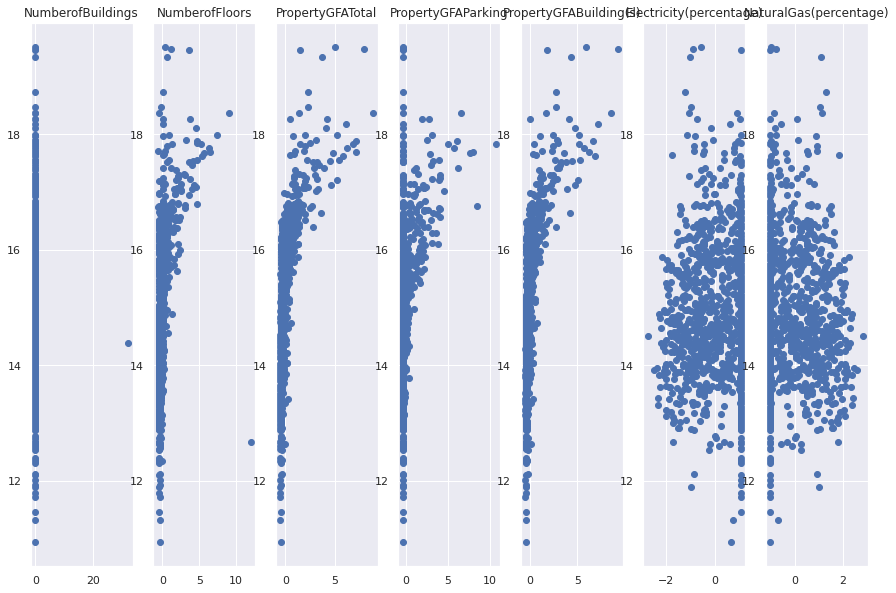

In [29]:
sns.set(rc = {'figure.figsize':(15,10)})
features = ['NumberofBuildings','NumberofFloors','PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'Electricity(percentage)', 
       'NaturalGas(percentage)']
fig, axs = plt.subplots(1,len(features))
for i, col in enumerate(features):
    x = X_energy[col]
    axs[i].scatter(x, y_energy, marker='o')
    axs[i].set_title(col)

<span style="color: #008080"> @ On sépare ensuite le jeu de donées en entraînement set et test set.
- Le jeu de test contiendra 30% des données. </span>

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_energy,y_energy, test_size = 0.3)
print(X_train.shape, X_test.shape)

(725, 19) (311, 19)


# Partie 4 : Les modèles de prédiction d'energie

<span style="color: #008080"> @ Dummy Regressor 
-
- Création d'une baseline comme la référence de comparaison
 </span>

In [31]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

# Prévision de l'échantillon de test
predDummy = dummy_regr.predict(X_test)

baseline_RMSE = np.sqrt(mean_squared_error(y_test, predDummy) )
baseline_r2 = r2_score(y_test, predDummy)
print("baseline_RMSE = %f, \nbaseline_r2 = %s"% (baseline_RMSE, baseline_r2))
print(" RMSE_normal = %s" % (np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predDummy)))))

baseline_RMSE = 1.171156, 
baseline_r2 = -0.01022460440659212
 RMSE_normal = 10892687.099185914


<span style="color: #008080"> @ Modèles linéaires
-
- Création du modèle
- Entraînement du modèle
- Evaluation du modèle
 </span>

In [32]:
from sklearn import linear_model

# On crée un modèle de régression linéaire
regLin = linear_model.LinearRegression()

# On entraîne ce modèle sur les données d'entrainement
regLin.fit(X_train,y_train)

# Prévision de l'échantillon de test
predLR = regLin.predict(X_test)

print("=== Sans Régularisation ===")
print("Weights: \n", regLin.coef_)


print("\n=== La performnce du modèle pour le set de Test ===")
print('R2 = {}'.format(r2_score( y_test, predLR)))
print("RMSE = {}".format(np.sqrt(mean_squared_error(y_test, predLR) )))  # la racine carrée d'erreur quadratique moyenne

=== Sans Régularisation ===
Weights: 
 [ 2.01298971e-01 -4.71061190e-03 -1.87503138e-02  1.06630437e-01
  1.16108183e-01  6.41481854e+13 -1.45241410e+13 -5.52450956e+13
  3.33525581e-02 -2.92353294e-01 -1.68512042e-01  2.22147268e-02
  3.85232788e+12  6.10581517e+12  4.54225608e+12  4.38049530e+12
  4.04668346e+12  3.82986782e+12  6.78415120e+12]

=== La performnce du modèle pour le set de Test ===
R2 = 0.40099211978639837
RMSE = 0.9018246559672098


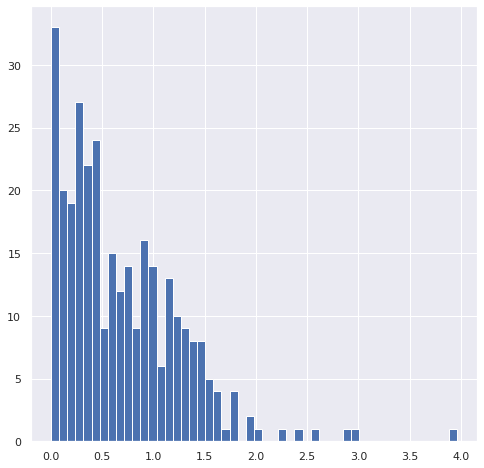

In [33]:
#Observation : Nos erreurs suivent une distribution expronentielle.
err_hist = np.abs(y_test - predLR)
plt.figure(figsize=(8,8))
plt.hist(err_hist, bins = 50)
plt.show()

<span style="color: #FF00FF"> @ Ridge : 
-
- Création du modèle : Application de la régression `ridge` avec 50 paramètres.
- Entraînement du modèle : On effectue notre différentes régressions ridge avec les différents hyperparamètres. 
- Evaluation du modèle : On teste un certain nombre d'hyperparamètres `alphas` pour appliquer le `ridge`; 
</span>

In [34]:
from sklearn.linear_model import Ridge
n_alphas = 50
alphas = np.logspace(-5, 8, n_alphas) # l'échelle logarithmique obenue avec logspace
ridge = linear_model.Ridge()

coefs = []
errors = []
r2s = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append(np.sqrt(mean_squared_error(y_test, ridge.predict(X_test))))
    r2s.append(r2_score(y_test, ridge.predict(X_test))) 

<span style="color: #FF00FF"> @ Ridge :  
-
- On affiche `la valeur de l'erreur` la plus petite  à l'aide de la fonction `argmin`;
</span>

In [35]:
print("=== Régularisation Ridge ===")
print("Weights: \n", coefs[np.argmin(errors)])
print("Alphas associée à l'erreur la plus petite erreur : ", alphas[np.argmin(errors)],"\n")

# Performence du modèle
print("Avec le test set : ")
print('R2 = {}'.format(r2s[np.argmin(errors)]))
print("RMSE = {}".format(errors[np.argmin(errors)]) )  # la racine carrée d'erreur quadratique moyenne

=== Régularisation Ridge ===
Weights: 
 [ 0.17548659 -0.01392764  0.00692443  0.04208657  0.08495207  0.3115137
  0.03998392  0.35120415  0.0948838  -0.0758532   0.04229319  0.02327834
 -0.02204143 -0.10149091  0.01265992 -0.06430694 -0.04231047 -0.00111427
  0.16277229]
Alphas associée à l'erreur la plus petite erreur :  79.06043210907701 

Avec le test set : 
R2 = 0.40765754863978576
RMSE = 0.8967931164201937


<span style="color: #FF00FF"> @ Ridge :
- 
- On affiche la valuer des erreurs et l'évolution des erreurs en fonction des hyperparamètres et comparer à notre baseline.  </span>
</span>

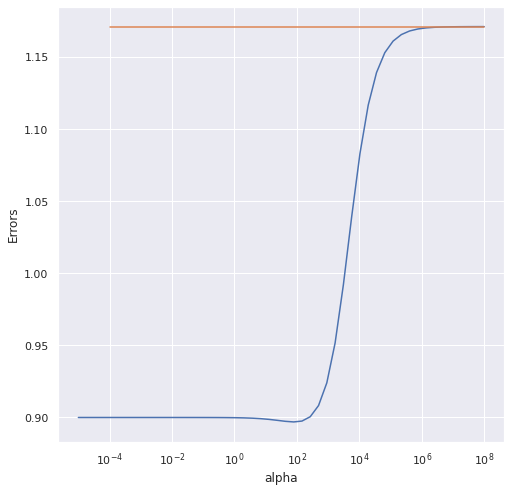

In [36]:
plt.figure(figsize=(8,8))
ax = plt.gca()
# On affiche les erreurs en fonction des alphas. On trace la droite de baseline_error.
ax.plot(alphas, errors,[10e-5, 10e7], [baseline_RMSE, baseline_RMSE])
ax.set_xscale('log') # on est sur une échelle logarithmique pour l'affichage.
plt.xlabel('alpha')
plt.ylabel('Errors')
plt.show()

<span style="color: #FF00FF"> @ Régression Ridge :
- On affiche `le chemin de régularisation` : </span>

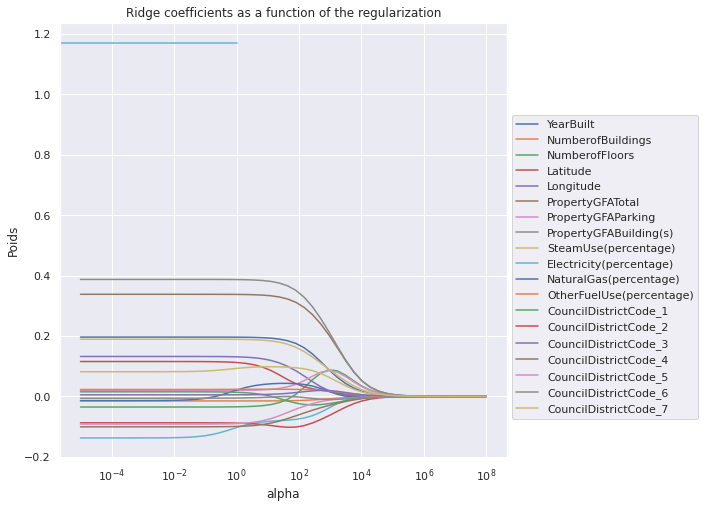

In [37]:
plt.figure(figsize=(8,8))
ax = plt.gca()

ax.plot(alphas, coefs,[baseline_RMSE,baseline_RMSE])
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Poids')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(X_energy.columns, bbox_to_anchor=(1, 0.8))
plt.show()

<span style="color: #FF00FF"> @ Ridge : Observarions : 
- On a vu sur la courbe de l'évolution des erreurs, il y a une chute de l'erreur qui a due à la régularisation vers `79.0`. 
- L'hyperparamètre n'a pas trop de l'influence juqu'au 79.0 : on voit que une impact de régularisaton a bien effecté et ensuite les erreurs augmente jusqu'au dépasser le baseline, donc il n'y a pas trop d'intérets d'utiliser ces hyperparamètres là.
- Donc ce qui nous intéresse c'est de récupérer la valeur d'alpha (le plus bas) environs `79.0`  </span>

<span style="color: #FF00FF"> @ Ridge : `GridSearchCV`
-
- Créatoin du modèle
- Performence du modèle
</span>


In [38]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
n_alphas = 50
alphas = np.logspace(-5, 8, n_alphas).tolist()
param=[{"alpha":alphas}]

regRidge = GridSearchCV(linear_model.Ridge(), param,cv=5,n_jobs=-1)
regRidgeOpt=regRidge.fit(X_train, y_train)

# paramètre optimal
print("alpha = {}".format(regRidgeOpt.best_params_['alpha']))

# Prévision de l'échantillon de test
predRidgeOpt = regRidgeOpt.predict(X_test)

# Performence du modèle
print("R2 =",r2_score(y_test,predRidgeOpt))
print("RMSE =",np.sqrt(mean_squared_error(y_test,predRidgeOpt)))

alpha = 145.63484775012444
R2 = 0.40685975202948765
RMSE = 0.8973968362489796


<span style="color: #008080"> @ Lasso :
-
 Application de la régression `Lasso`
- On teste 300 hyperparamètres pour appliquer le lasso </span>

In [39]:
n_alphas = 300
alphas = np.logspace(-5, 3, n_alphas)

lasso = linear_model.Lasso()

coefs = []
errors = []
r2s =[]
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append( np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))))
    r2s.append(r2_score(y_test,lasso.predict(X_test)))

/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.898e+00, tolerance: 1.197e-01
  model = cd_fast.enet_coordinate_descent(
/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.776e+00, tolerance: 1.197e-01
  model = cd_fast.enet_coordinate_descent(
/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.777e+00,

In [40]:
print("=== Régularisation Lasso ===")
print("Weights: \n", coefs[np.argmin(errors)])
print("alpha: \n", alphas[np.argmin(errors)])
print("\n=== La performence du modèle pour le set de Training ===")
print('R2 = {}'.format(r2s[np.argmin(errors)]))
print("RMSE = {}".format(errors[np.argmin(errors)]) )  # la racine carrée d'erreur quadratique moyenne

=== Régularisation Lasso ===
Weights: 
 [ 0.16322564 -0.          0.          0.          0.04209895  0.41844268
  0.          0.29554234  0.06944414 -0.10408435  0.          0.
 -0.0106464  -0.07167453  0.02702565 -0.00460299  0.          0.
  0.18247501]
alpha: 
 0.023509178754572868

=== La performence du modèle pour le set de Training ===
R2 = 0.4203914784801611
RMSE = 0.8871013044627132


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


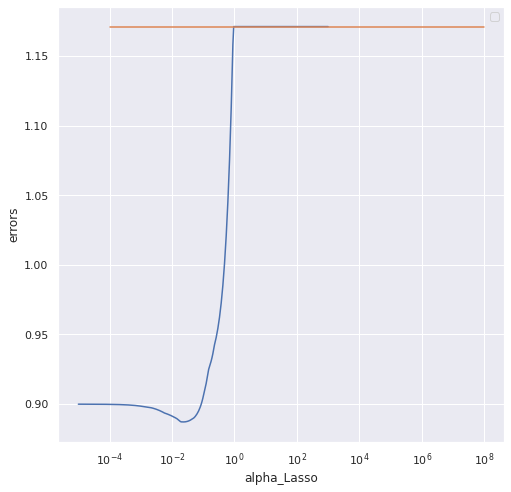

In [41]:
plt.figure(figsize=(8,8))
ax = plt.gca()
ax.legend()
ax.plot(alphas, errors,[10e-5, 10e7], [baseline_RMSE, baseline_RMSE])
ax.set_xscale('log')
plt.xlabel('alpha_Lasso')
plt.ylabel('errors')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


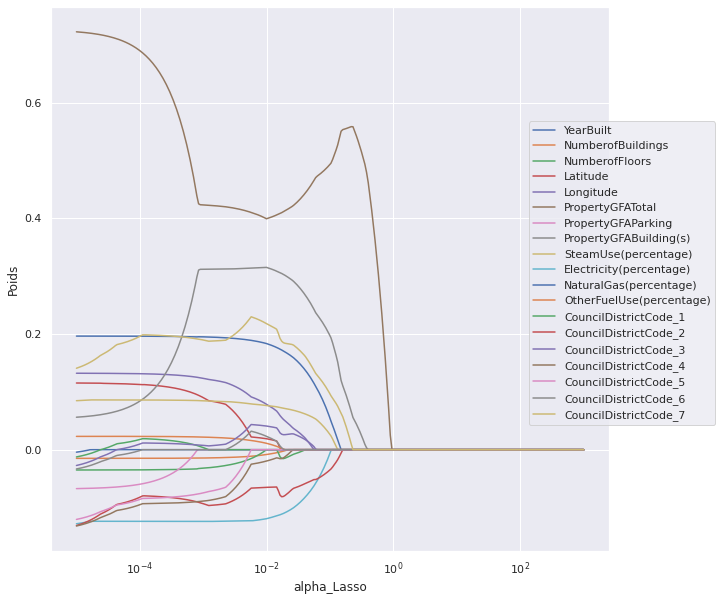

In [42]:
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.legend()
plt.xlabel('alpha_Lasso')
plt.ylabel('Poids')
plt.legend(X_energy.columns, bbox_to_anchor=(1.2, 0.8))
plt.show()

<span style="color: #008080"> @ Lasso : `GridSearchCV`
-
 </span>

In [43]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
n_alphas = 300
alphas = np.logspace(-4, 3, n_alphas).tolist()
param=[{"alpha":alphas}]

regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, y_train)

# paramètre optimal
print("Train set : Meilleur paramètre alpha = %f" % regLassOpt.best_params_['alpha'])

# Prévision de l'échantillon de test
predLassOpt=regLassOpt.predict(X_test)

# Performence du modèle
print("R2 = %f , \n RMSE = %s"% (r2_score(y_test,predLassOpt), np.sqrt(mean_squared_error(predLassOpt,y_test))))

/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.698e+00, tolerance: 9.612e-02
  model = cd_fast.enet_coordinate_descent(
/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.491e+00, tolerance: 9.446e-02
  model = cd_fast.enet_coordinate_descent(
/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.769e+00,

Train set : Meilleur paramètre alpha = 0.030311
R2 = 0.419952 , 
 RMSE = 0.8874376464152898


In [44]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(X_train,y_train)
model_lasso.coef_

array([ 0.15315955, -0.        ,  0.        ,  0.        ,  0.03215425,
        0.42811226,  0.        ,  0.28470966,  0.06638851, -0.09540886,
        0.        ,  0.        , -0.00577634, -0.06452633,  0.02462293,
       -0.        ,  0.        ,  0.        ,  0.17560522])

In [45]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 10 variables et en supprime 9


Text(0.5, 1.0, 'Coefficients du modèle lasso')

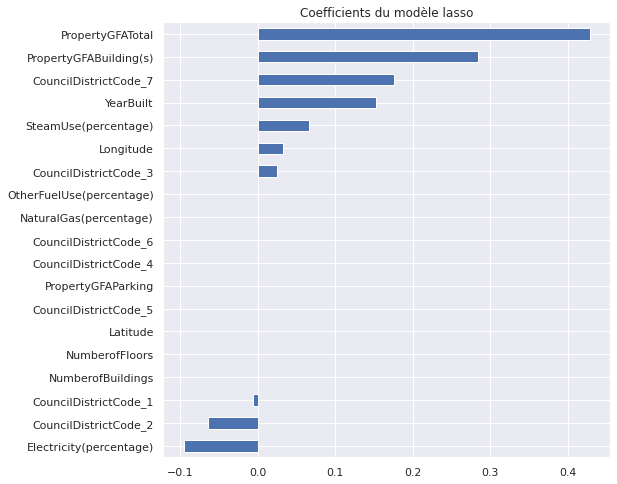

In [46]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 8.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients du modèle lasso")

<span style="color: #FF00FF"> @ SVR : `GridSearchCV`
-
- Créatoin du modèle
- Performence du modèle
</span>


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
# grille de valeurs du paramètre à optimiser
param = {'kernel' : ('linear','rbf'),'C' : [4,5,6],'degree' : [1,2,3],'coef0' : [0.001,0.01,0.1],'gamma' : ('auto','scale')},
model_SVR = SVR()
regSVR = GridSearchCV(estimator = model_SVR, param_grid = param,  cv = 5, n_jobs = -1, verbose = 2)

regSVROpt = regSVR.fit(X_train,y_train)

# paramètre optimal
print("\n Meilleur paramètre =", regSVROpt.best_params_)

# Prévision de l'échantillon de test
predSVROpt =regSVROpt.predict( X_test)

# Performence du modèle
print(" R2 = %f,\n RMSE = %s" % (regSVROpt.best_score_, np.sqrt(mean_squared_error(y_test, predSVROpt))))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END .C=4, coef0=0.001, degree=1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .C=4, coef0=0.001, degree=1, gamma=auto, kernel=rbf; total time=   0.2s
[CV] END .C=4, coef0=0.001, degree=1, gamma=auto, kernel=rbf; total time=   0.2s
[CV] END C=4, coef0=0.001, degree=1, gamma=auto, kernel=linear; total time=   0.3s
[CV] END C=4, coef0=0.001, degree=1, gamma=auto, kernel=linear; total time=   0.3s
[CV] END C=4, coef0=0.001, degree=1, gamma=auto, kernel=linear; total time=   0.3s
[CV] END C=4, coef0=0.001, degree=1, gamma=auto, kernel=linear; total time=   0.4s
[CV] END .C=4, coef0=0.001, degree=1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .C=4, coef0=0.001, degree=1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END C=4, coef0=0.001, degree=1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END C=4, coef0=0.001, degree=1, gamma=auto, kernel=linear; total time=   0.6s
[CV] END C=4, coef0=0.001, degree=1,

<span style="color: #008080"> @ RandomForestRegression : `GridSearchCV` 
-
 </span>

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor()
para_grids = {
            "n_estimators" : [40,50,60],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False],
            "max_depth" : [6,8,10, 12]
        }


grid = GridSearchCV(estimator, para_grids,cv=5, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
forest = grid.best_estimator_

# Prévision de l'échantillon de test
reg_prediction=forest.predict(X_test)

print (grid.best_score_,"\n Les meilleurs paramètres :", grid.best_params_)
print(" R2 = %f, \n RMSE = %s" % (r2_score(y_test, reg_prediction),np.sqrt(mean_squared_error(y_test, reg_prediction))))
print(" RMSE_normal = %s" % (np.sqrt(mean_squared_error(np.exp(y_test), np.exp(reg_prediction)))))

-0.47878267558586557 
 Les meilleurs paramètres : {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
 R2 = 0.668670, 
 RMSE = 0.6707117609376603
 RMSE_normal = 7017537.498607752


<span style="color: #008080"> @ RandomForestRegression : 
- On affiche les features selon l'ordre d'importance décroissant.
 </span>

In [49]:
importance = pd.Series(forest.feature_importances_, X_train.columns)
importance.sort_values(ascending=False)

PropertyGFATotal            0.298642
PropertyGFABuilding(s)      0.253712
NumberofFloors              0.142858
PropertyGFAParking          0.066987
Electricity(percentage)     0.044909
YearBuilt                   0.044675
Latitude                    0.042721
Longitude                   0.035495
NaturalGas(percentage)      0.030147
SteamUse(percentage)        0.013817
CouncilDistrictCode_7       0.007500
CouncilDistrictCode_2       0.006153
CouncilDistrictCode_3       0.004299
CouncilDistrictCode_4       0.003497
CouncilDistrictCode_6       0.001767
CouncilDistrictCode_1       0.001361
CouncilDistrictCode_5       0.001265
OtherFuelUse(percentage)    0.000185
NumberofBuildings           0.000009
dtype: float64

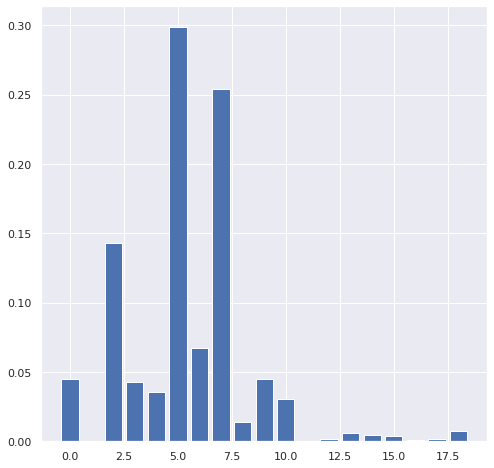

In [50]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### @ Conclusion: 
Le modèle le plus performant pour prédire la cosommation d'énergie est le modèle `RandomForestRegression` avec r2 = 0.6687 et rmse = 0.6707.

 </span>